# Перемешиваем модальности

# Metadata
transforms, model+optimizer+loss, hyperparams

In [8]:
TITLE = "int+flip, context-SegResNetDS+adan+dicefocal"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *
from glio.specific.vkr import *
from glio.transforms.intensity import RandScale, RandShift
from glio.transforms.spatial import RandFlipt

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
bratstrain = get_ds_around(BRATS2024_NOHIST96_TRAIN) + get_ds_around(BRATS2024_NOHIST96_TEST)
rhuhtest = get_ds_around(RHUH_NOHIST140_NOADC_TRAIN) + get_ds_around(RHUH_NOHIST140_NOADC_TEST)

In [4]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

from monai import transforms as mtf

# fast tfms
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore

# slower tfms
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore

# very slow
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore

def rand_shuffle_channels_around(x:torch.Tensor, channels_per = 3):
    if random.random() < 0.1:
        num_groups = int(x.shape[0] / channels_per)
        perm = torch.randperm(num_groups, dtype=torch.int32)
        img= x.reshape(num_groups, channels_per, *x.shape[1:])[perm].flatten(0, 1)
        return img
    return x

def rand_group_dropout(x):
    if random.random() < 0.05: return torch.zeros_like(x)
    if random.random() < 0.05: return torch.randn_like(x)
    return x

def randnoise(x):
    if random.random() < 0.1: return x + torch.randn_like(x) * random.triangular(0, 0.5, 0)
    return x


In [5]:
dstrain.add_samples(bratstrain, loader_around_seq_fix, RandFlipt(p=0.5), [get0, rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3), RandShift(p=0.3), rand_group_dropout))], get1)
dstest.add_samples(rhuhtest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

332625
20893


# Performance

In [40]:
x = torch.randn((3,96,96))
with perf_counter_context():
    for i in range(100):
        dstrain[i]

Context took 0.431979599990882 perf_counter seconds


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

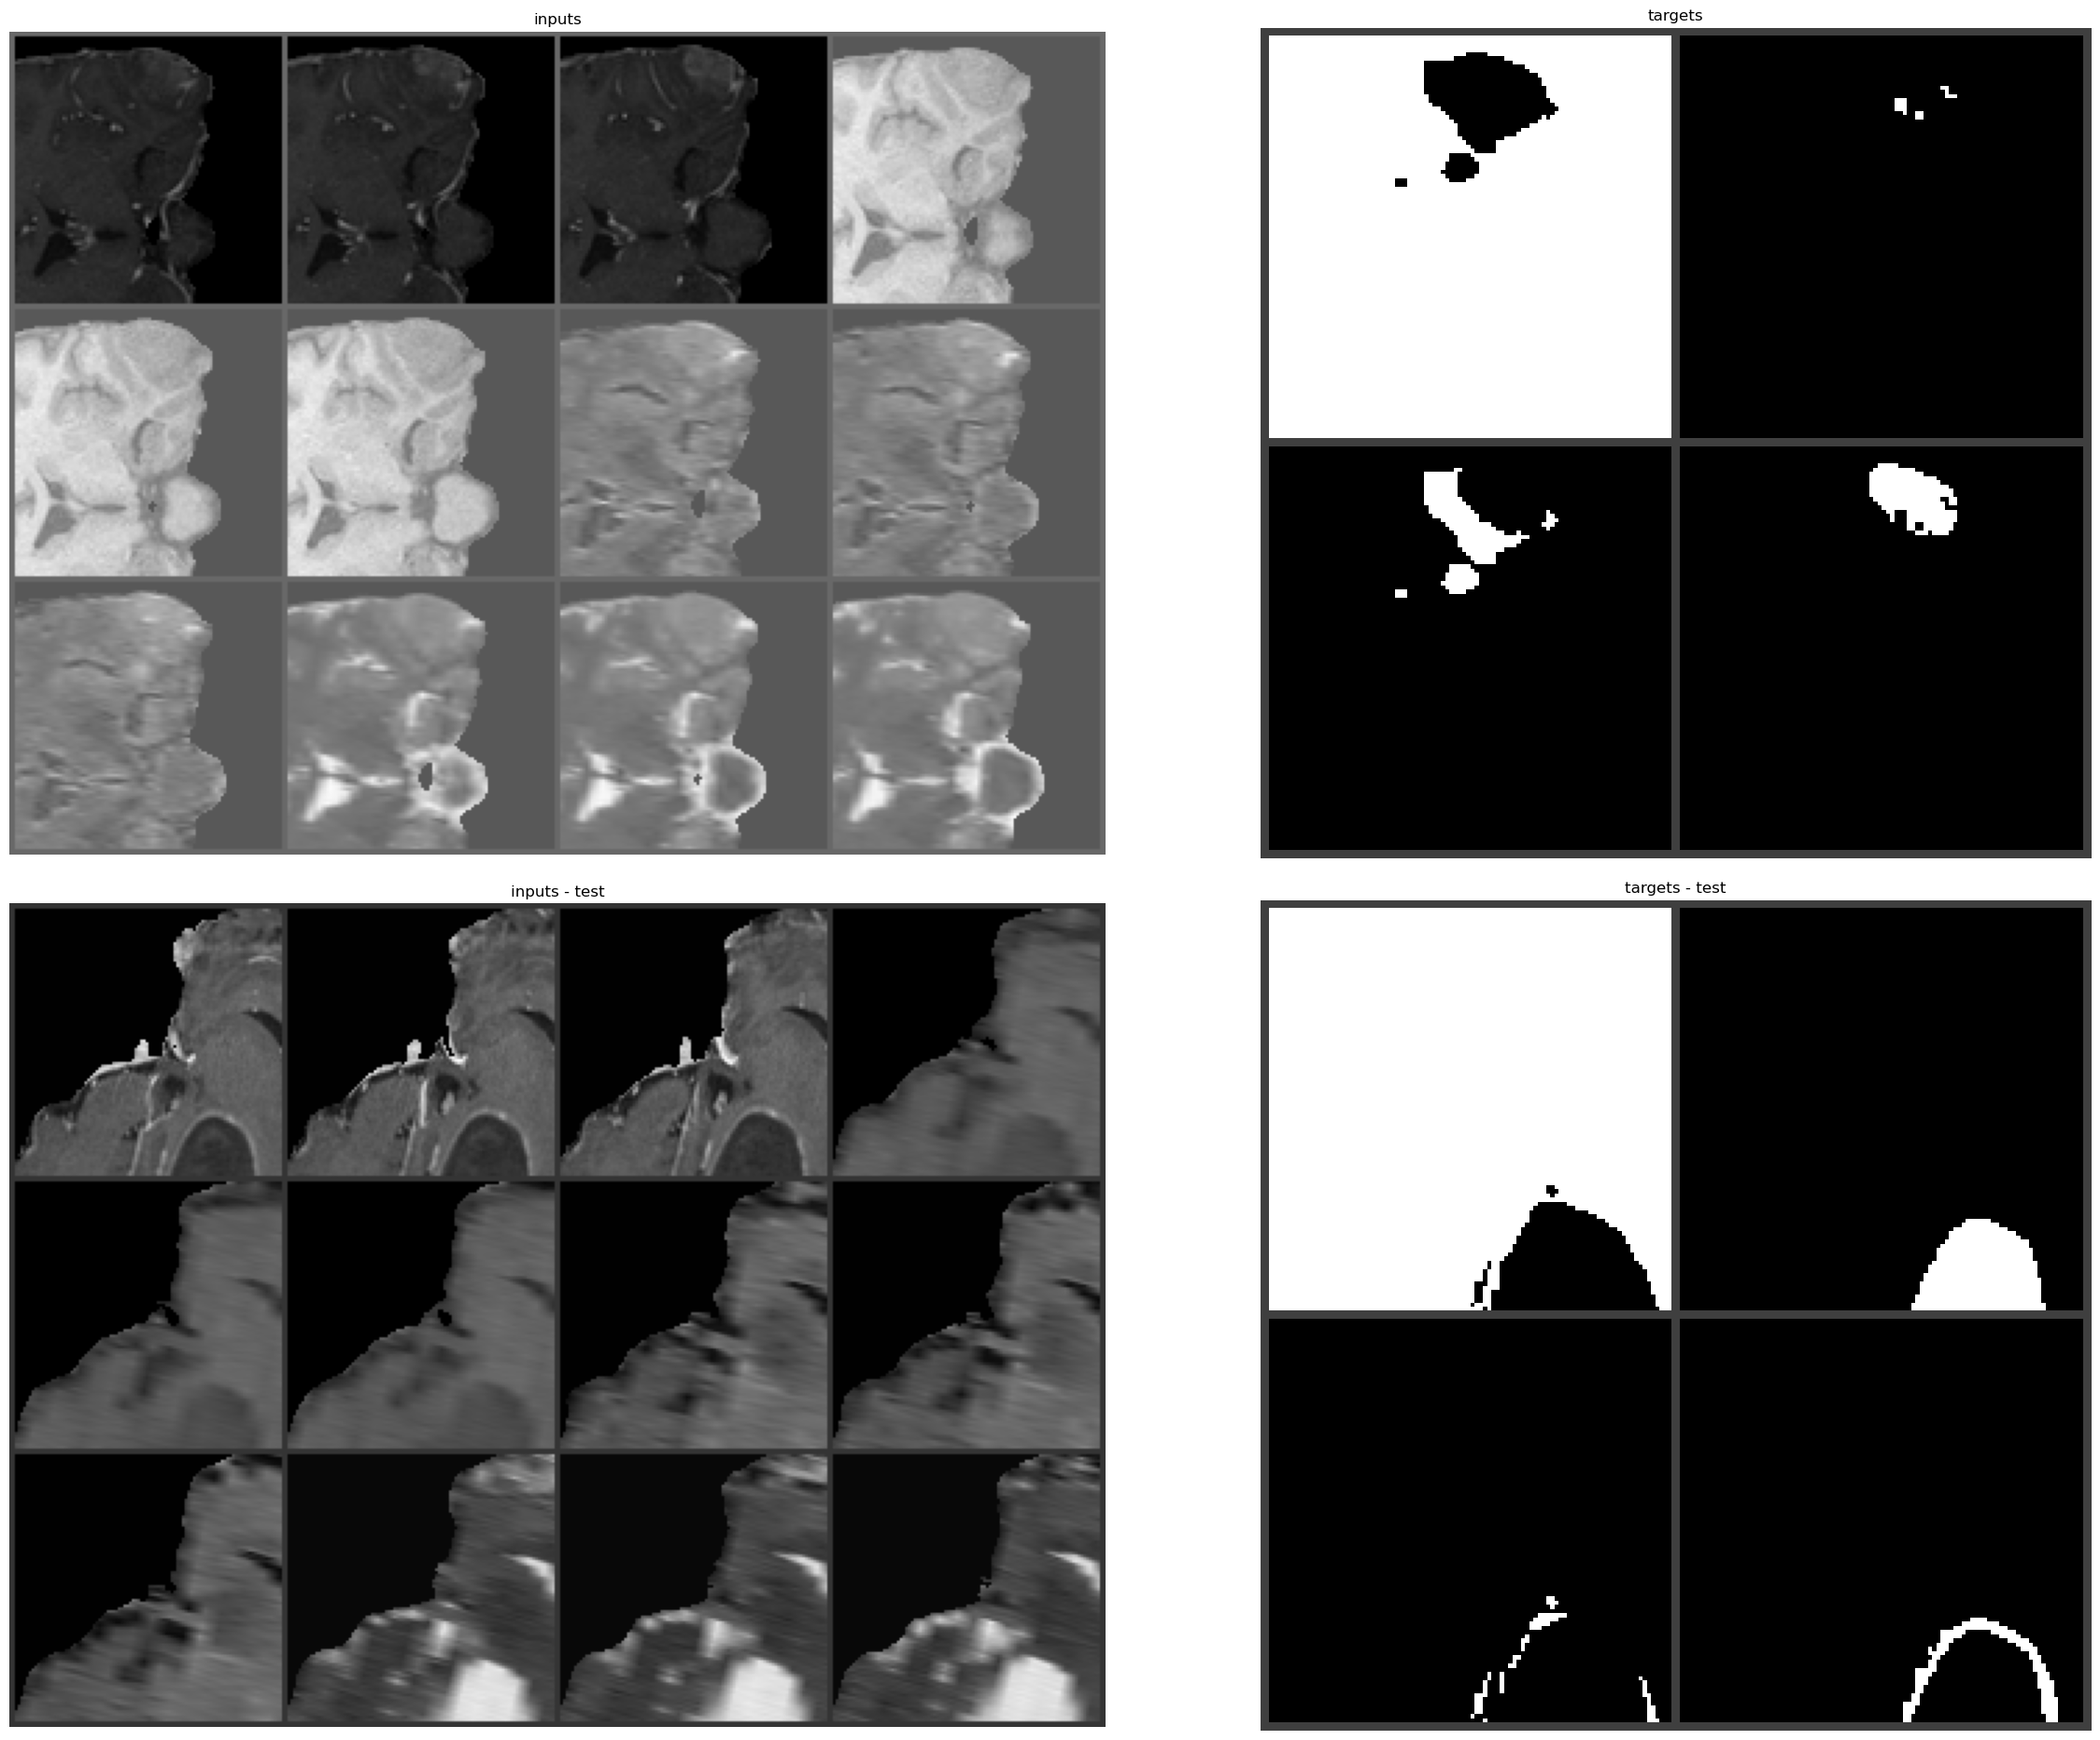

In [41]:
fig = Figure()
sample_ = dstrain[310]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [9]:
from monai.networks.nets import SegResNetDS # type:ignore
print(f"{count_parameters(SegResNetDS(2, 32, 12, 4)) = }")

count_parameters(SegResNetDS(2, 32, 12, 4)) = 6645764


In [20]:
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(12,24,5,1, batch_norm=True, pool=nn.MaxPool2d(2,2), act=nn.GELU())
        self.conv2 = conv(24,36,2,1, batch_norm=True, pool=nn.MaxPool2d(2,2), act=nn.GELU())
        self.conv3 = conv(36,48,2,1, batch_norm=True, pool=nn.MaxPool2d(2,2), act=nn.GELU())
        self.conv4 = conv(48,60,2,1, batch_norm=True, pool=nn.MaxPool2d(2,2), act=nn.GELU())
        self.conv5 = conv(60,72,2,1, batch_norm=True, pool=nn.MaxPool2d(2,2), act=nn.GELU())
        
        self.upconv1 = convt(72, 60, 3, 2, batch_norm=True, act=nn.GELU())
        self.upconv2 = convt(60, 48, 2, 2, batch_norm=True, act=nn.GELU())
        self.upconv3 = convt(48, 36, 2, 2, batch_norm=True, act=nn.GELU())
        self.upconv4 = convt(36, 32, 2, 2, batch_norm=True, act=nn.GELU())
        self.upconv5 = convt(32, 24, 2, 2, batch_norm=True, act = nn.GELU())
        self.upconv6 = convt(24, 20, 2, 2, batch_norm=True, act = None)
        
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.upconv1(x)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)
        x = self.upconv5(x)
        x = self.upconv6(x)

        return x
    
summary(Autoenc(), (4, 12, 96, 96))

path                                         module                                       input size               output size              params    buffers   
__main__.Autoenc/conv1/0                     torch.nn.modules.conv.Conv2d                 (4, 12, 96, 96)          (4, 24, 92, 92)          7224      0         
__main__.Autoenc/conv1/1                     torch.nn.modules.pooling.MaxPool2d           (4, 24, 92, 92)          (4, 24, 46, 46)          0         0         
__main__.Autoenc/conv1/2                     torch.nn.modules.activation.GELU             (4, 24, 46, 46)          (4, 24, 46, 46)          0         0         
__main__.Autoenc/conv1/3                     torch.nn.modules.batchnorm.BatchNorm2d       (4, 24, 46, 46)          (4, 24, 46, 46)          48        49        
__main__.Autoenc/conv2/0                     torch.nn.modules.conv.Conv2d                 (4, 24, 46, 46)          (4, 36, 45, 45)          3492      0         
__main__.Autoenc/conv2/1          

In [21]:
class ContextResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = SegResNetDS(2, 32, 32, 4)
        self.autoenc = Autoenc()

    def forward(self, x:torch.Tensor):
        self.context = self.autoenc(x)
        return self.resnet(torch.cat([x, self.context], 1))
    
summary(ContextResNet(), (4, 12, 96, 96))

path                                         module                                       input size               output size              params    buffers   
__main__.ContextResNet/autoenc/conv1/0       torch.nn.modules.conv.Conv2d                 (4, 12, 96, 96)          (4, 24, 92, 92)          7224      0         
__main__.ContextResNet/autoenc/conv1/1       torch.nn.modules.pooling.MaxPool2d           (4, 24, 92, 92)          (4, 24, 46, 46)          0         0         
__main__.ContextResNet/autoenc/conv1/2       torch.nn.modules.activation.GELU             (4, 24, 46, 46)          (4, 24, 46, 46)          0         0         
__main__.ContextResNet/autoenc/conv1/3       torch.nn.modules.batchnorm.BatchNorm2d       (4, 24, 46, 46)          (4, 24, 46, 46)          48        49        
__main__.ContextResNet/autoenc/conv2/0       torch.nn.modules.conv.Conv2d                 (4, 24, 46, 46)          (4, 36, 45, 45)          3492      0         
__main__.ContextResNet/autoenc/con

# Train

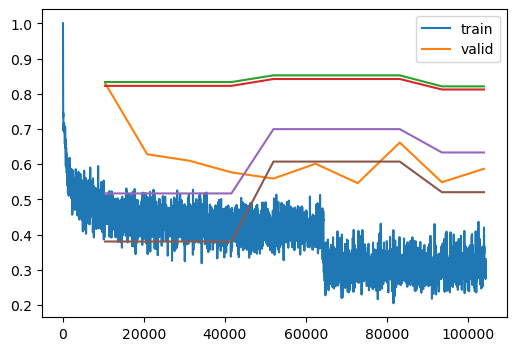

Keyboard interrupt, stopping the training...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

FileNotFoundError: [Errno 2] No such file or directory: 'summaries/int+flip, context-SegResNetDS+adan+dicefocal lr2e-03 OneCycleLR testloss-0.546.png'

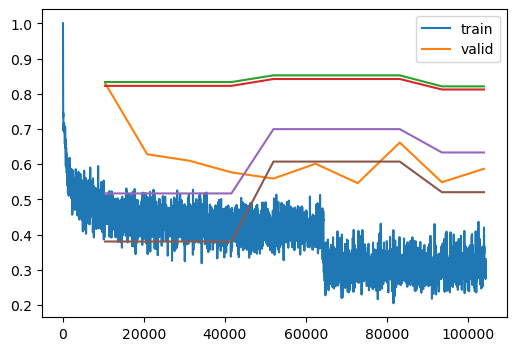

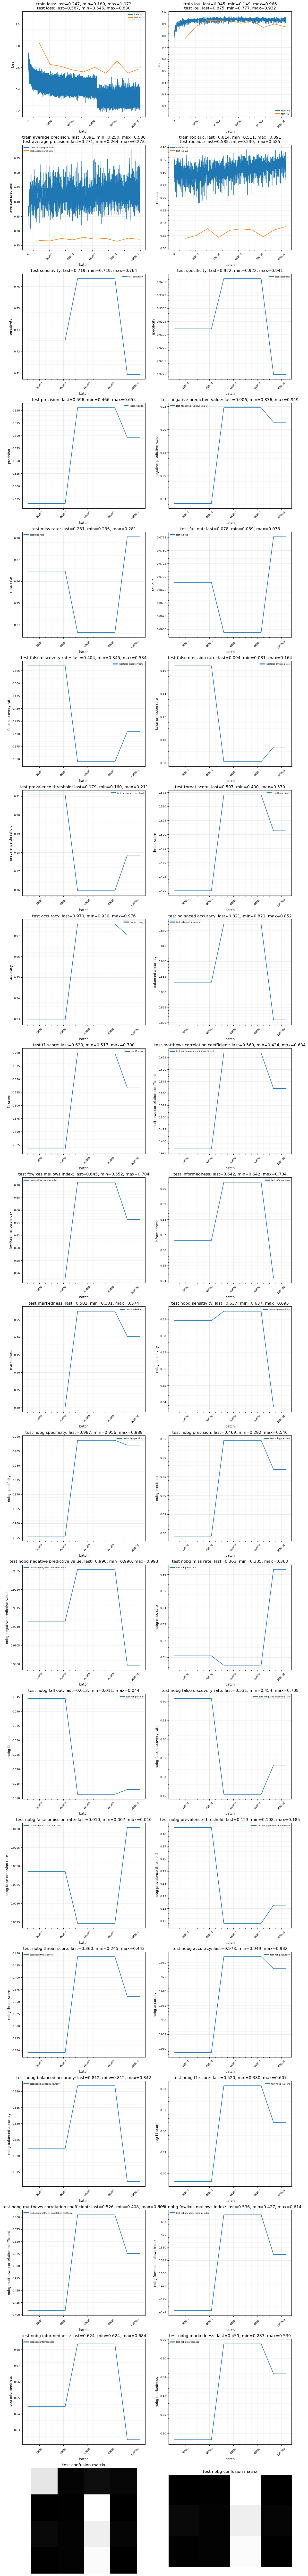

In [42]:
from stuff.found.torch.optim.Adan import Adan
from monai.losses import DiceFocalLoss # type:ignore

MODEL = ContextResNet()
NAME = f"{MODEL.__class__.__name__}"
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 150

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = Adan(MODEL.parameters(), lr=LR)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(),
              Log_Time(), Save_Best(), Save_Last(), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              MONAI_ConfusionMatrix(step=4), MONAI_ConfusionMatrixMetrics(),
              MONAI_ConfusionMatrix(step=4, include_bg = False, name="nobg confusion matrix"), MONAI_ConfusionMatrixMetrics(key = 'nobg confusion matrix', prefix='nobg '),
              FastProgressBar(step_batch=128, plot=True, metrics=('train loss', 'test loss', 
                                                                  'test balanced accuracy', 'test nobg balanced accuracy',
                                                                  'test f1 score', 'test nobg f1 score'), maxv=1),
              Summary(),
              PlotSummary(path='summaries'),
              PrintLoss(),
              SaveReferenceVisualizationsAfterEachEpoch('reference preds'),
              #Metric_PredsTargetsFn(LOSS_FN, name='dice loss'),
              #CallTrainAndEvalOnOptimizer(),
              #AddLossReturnedByModelToLossInBackward(),
            )

LEARNER_NAME = f"{TITLE} lr{LR:.0e} OneCycleLR"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False)
plt.show()


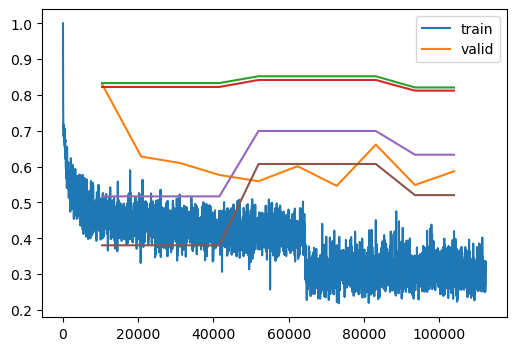

Keyboard interrupt, stopping the training...
time: min: 4.8143; max: 43522.7467; last: 43522.7467
lr: min: 0.0001; max: 0.0019; last: 0.0019
train loss: min: 0.1693; max: 1.0724; last: 0.3005
train iou: min: 0.1493; max: 0.9659; last: 0.9337
train average precision: min: 0.2501; max: 0.5797; last: 0.4707
train roc auc: min: 0.5110; max: 0.8911; last: 0.8370
test loss: min: 0.5462; max: 0.8301; last: 0.5869
test iou: min: 0.7769; max: 0.9325; last: 0.8753
test average precision: min: 0.2640; max: 0.2779; last: 0.2709
test roc auc: min: 0.5387; max: 0.5848; last: 0.5848
test sensitivity: min: 0.7194; max: 0.7636; last: 0.7194
test specificity: min: 0.9224; max: 0.9406; last: 0.9224
test precision: min: 0.4656; max: 0.6551; last: 0.5957
test negative predictive value: min: 0.8358; max: 0.9189; last: 0.9062
test miss rate: min: 0.2364; max: 0.2806; last: 0.2806
test fall out: min: 0.0594; max: 0.0776; last: 0.0776
test false discovery rate: min: 0.3449; max: 0.5344; last: 0.4043
test false

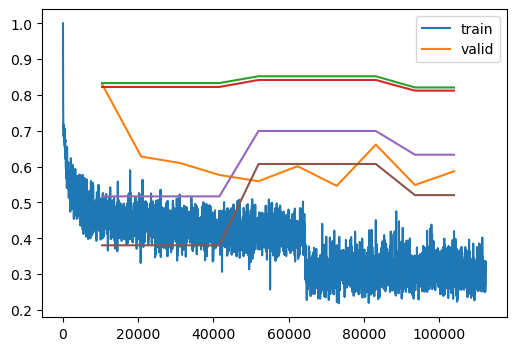

In [58]:
LR = 1e-2
OPT = Adan(learner.model.autoenc.parameters(), lr=LR)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=10)

learner.fit(10, dltrain, dltest, False, test_on_interrupt = False, extra = (Set_Optimizer(OPT), Set_Scheduler(SCHED)))

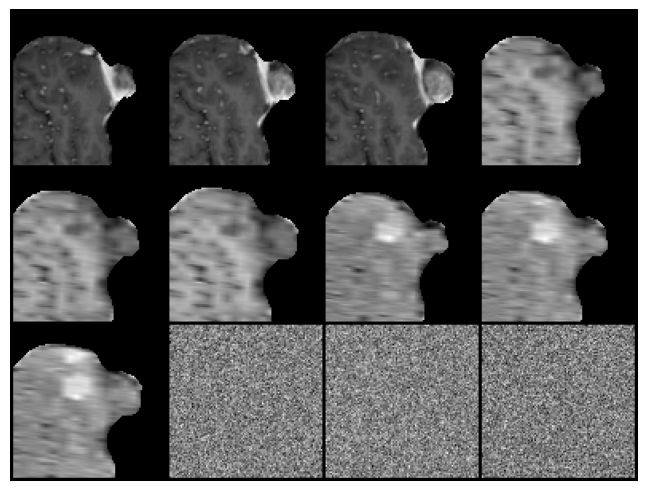

In [59]:
inputs = dstrain[0][0]
qimshow_batch(inputs, scale_each = True)

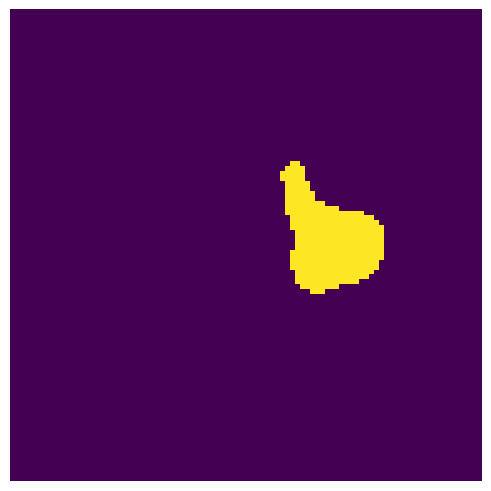

In [60]:
preds = learner.inference(inputs.unsqueeze(0))
qimshow(preds[0].argmax(0))

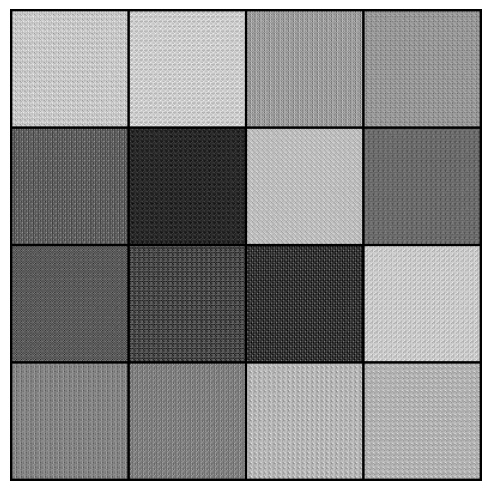

In [61]:
qimshow_batch(learner.model.context[0])